In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import xgboost as xgb 
from sklearn.metrics import mean_squared_error 
color_pal=sns.color_palette()
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns',200)

In [8]:
df=pd.read_csv("PJME_Hourly.csv")
df

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
...,...,...
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0


In [9]:
df=df.set_index('Datetime')
df.index=pd.to_datetime(df.index)
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


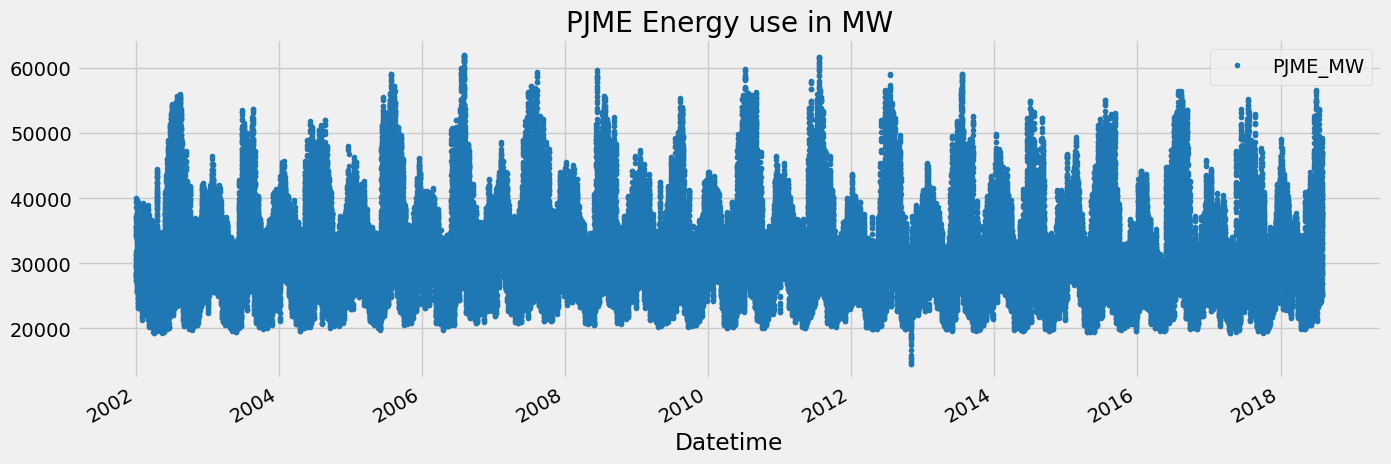

In [18]:
df.plot(style='.',
       figsize=(15,5),
       color=color_pal[0],
       title="PJME Energy use in MW")
plt.show()

Outlier Analysis and Removal

<Axes: ylabel='Frequency'>

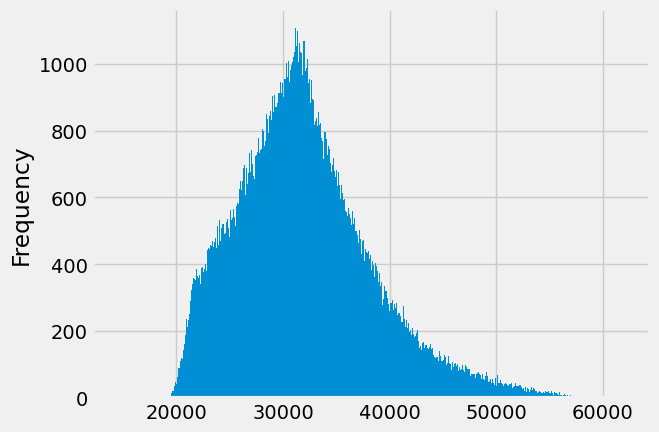

In [19]:
df["PJME_MW"].plot(kind='hist',bins=500)

<Axes: xlabel='Datetime'>

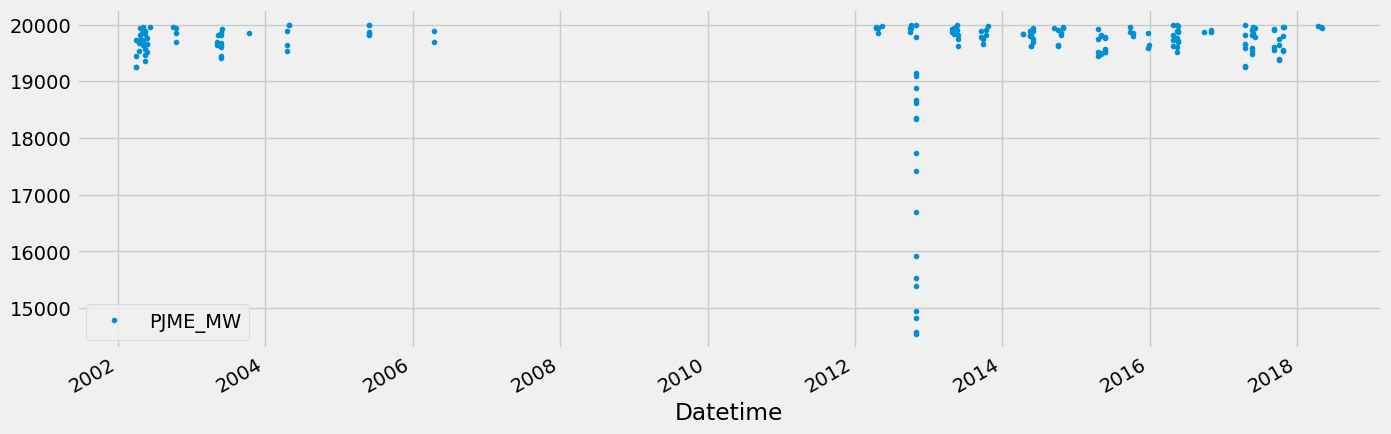

In [23]:
df.query("PJME_MW<20000").plot(figsize=(15,5),style=".")

In [24]:
df=df.query('PJME_MW > 19000').copy()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [27]:
from sklearn.model_selection import TimeSeriesSplit
tss=TimeSeriesSplit(n_splits=5,test_size=24*365*1,gap=24)
df=df.sort_index()

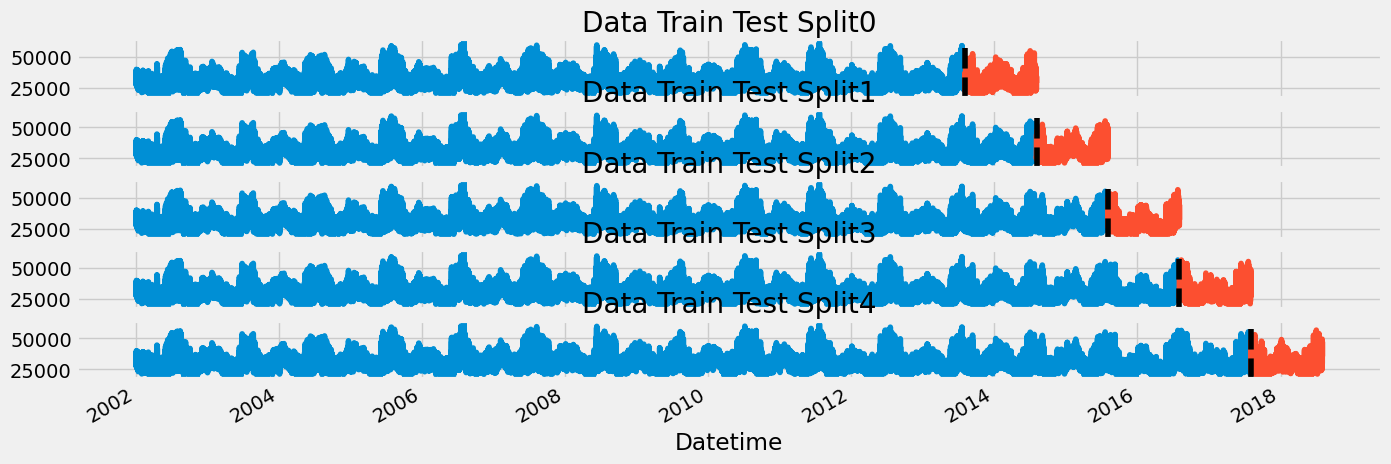

In [34]:
fig, axs = plt.subplots(5, 1, figsize=(15, 5),
                        sharex=True)
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train["PJME_MW"].plot(ax=axs[fold], label="Training Set", title=f"Data Train Test Split{fold}")
    test["PJME_MW"].plot(ax=axs[fold], label="Test Set")
    axs[fold].axvline(test.index.min(), color="black", ls='--')
    fold += 1


In [35]:
def create_features(df):
    df=df.copy()
    df['hour']=df.index.hour
    df["dayofweek"]=df.index.dayofweek
    df["quarter"]=df.index.quarter
    df["month"]=df.index.month
    df["year"]=df.index.year
    df["dayofyear"]=df.index.dayofyear
    return df
df=create_features(df)

In [36]:
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1
...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214


3.Lag Feature

In [37]:
target_map=df["PJME_MW"].to_dict()

In [42]:
def add_lags(df):
    df["lag1"]=(df.index-pd.Timedelta('364 days')).map(target_map)
    df["lag2"]=(df.index-pd.Timedelta('728 days')).map(target_map)
    df["lag3"]=(df.index-pd.Timedelta('1092 days')).map(target_map)
    return df
df=add_lags(df)

In [44]:
df.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,39525.0,38698.0,37330.0
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,36490.0,35406.0,34552.0
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,33539.0,32094.0,31695.0


In [45]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32732.49608	validation_1-rmse:31956.60163


C:\Users\Hp\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [19:15:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12532.64369	validation_1-rmse:11906.14134
[200]	validation_0-rmse:5747.92495	validation_1-rmse:5359.26490
[300]	validation_0-rmse:3872.48134	validation_1-rmse:3900.86965
[400]	validation_0-rmse:3434.23853	validation_1-rmse:3762.33705
[442]	validation_0-rmse:3369.34730	validation_1-rmse:3764.82810
[0]	validation_0-rmse:32672.16678	validation_1-rmse:32138.89241


C:\Users\Hp\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [19:15:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12513.65574	validation_1-rmse:12224.93373
[200]	validation_0-rmse:5753.34937	validation_1-rmse:5662.07107
[300]	validation_0-rmse:3902.71304	validation_1-rmse:3933.73076
[400]	validation_0-rmse:3476.90515	validation_1-rmse:3590.55005
[500]	validation_0-rmse:3353.72424	validation_1-rmse:3516.39915
[600]	validation_0-rmse:3297.94766	validation_1-rmse:3481.94003
[700]	validation_0-rmse:3258.48267	validation_1-rmse:3461.37383
[800]	validation_0-rmse:3221.51553	validation_1-rmse:3436.49603
[900]	validation_0-rmse:3190.11480	validation_1-rmse:3428.88699
[999]	validation_0-rmse:3166.16314	validation_1-rmse:3420.31309
[0]	validation_0-rmse:32631.20370	validation_1-rmse:31073.29733


C:\Users\Hp\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [19:15:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12499.28425	validation_1-rmse:11136.70202
[200]	validation_0-rmse:5750.81453	validation_1-rmse:4813.22087
[300]	validation_0-rmse:3917.04200	validation_1-rmse:3553.46419
[400]	validation_0-rmse:3494.55924	validation_1-rmse:3495.32356
[410]	validation_0-rmse:3476.66883	validation_1-rmse:3502.25535
[0]	validation_0-rmse:32528.44438	validation_1-rmse:31475.39670


C:\Users\Hp\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [19:15:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12462.36581	validation_1-rmse:12020.28283
[200]	validation_0-rmse:5738.57925	validation_1-rmse:5796.45874
[300]	validation_0-rmse:3918.53218	validation_1-rmse:4388.39477
[400]	validation_0-rmse:3501.24270	validation_1-rmse:4173.36380
[500]	validation_0-rmse:3384.02490	validation_1-rmse:4119.56538
[600]	validation_0-rmse:3325.50024	validation_1-rmse:4105.01446
[700]	validation_0-rmse:3282.73755	validation_1-rmse:4091.23557
[800]	validation_0-rmse:3250.37610	validation_1-rmse:4083.12690
[900]	validation_0-rmse:3223.87814	validation_1-rmse:4081.46154
[999]	validation_0-rmse:3199.82843	validation_1-rmse:4052.57120
[0]	validation_0-rmse:32462.05557	validation_1-rmse:31463.90500


C:\Users\Hp\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [19:16:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12445.87740	validation_1-rmse:11963.42706
[200]	validation_0-rmse:5752.44568	validation_1-rmse:5611.92884
[300]	validation_0-rmse:3951.51709	validation_1-rmse:4156.41403
[400]	validation_0-rmse:3539.25569	validation_1-rmse:4006.58873
[439]	validation_0-rmse:3480.87364	validation_1-rmse:4011.68406


In [46]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3742.5833
Fold scores:[3760.8277187583353, 3420.313091887879, 3478.018038580526, 4052.5712055405547, 4001.186553933809]


In [47]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32403.88991


C:\Users\Hp\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:18:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)


[100]	validation_0-rmse:12426.83220
[200]	validation_0-rmse:5751.73275
[300]	validation_0-rmse:3971.53256
[400]	validation_0-rmse:3571.21833
[499]	validation_0-rmse:3456.76877


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [48]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [49]:
future_w_features = df_and_future.query('isFuture').copy()

In [50]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])


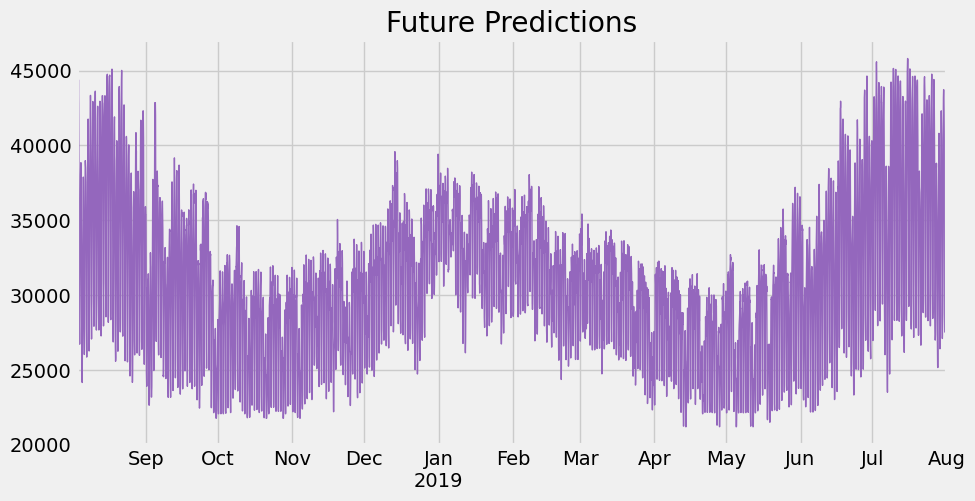

In [51]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()